### Task 1:
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
#### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [182]:
from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
matplotlib.use('qt4agg')  # Can also use 'tkagg' or 'webagg'

import matplotlib.pyplot as pl
import statsmodels.api as sm

import os
import json
import seaborn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [183]:
mtaRides = np.load(os.getenv('PUIDATA') + '/MTA_Fare.npy')

In [184]:
shape(mtaRides)

(600, 23, 194)

In [185]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [186]:
# create a data range start from 05/21/2010 to 02/21/2014
dateindex = pd.date_range(start = '05/21/2010', end = '02/21/2014', freq='7d')

In [187]:
dateindex

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-12-20', '2013-12-27', '2014-01-03', '2014-01-10',
               '2014-01-17', '2014-01-24', '2014-01-31', '2014-02-07',
               '2014-02-14', '2014-02-21'],
              dtype='datetime64[ns]', length=197, freq='7D')

In [188]:
len(dateindex)

197

### There are 197 weeks from 05/21/2010 to 02/21/2014. It does not match the 194 weeks data. So I failed to set the datetime as index to the mtaRides dataframe.

In [189]:
type(mtaRides[1][1][1])

numpy.int32

In [190]:
# convert the data to float type
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides == -1] = numpy.nan

In [191]:
# sum time series for all stations
print (mtaRides.shape)
mta_sumstation = np.nansum(mtaRides, axis=0)
print (mta_sumstation.shape)
# for all ride types
mta_sumtype = np.nansum(mtaRides, axis=1)
print (mta_sumtype.shape)

(600, 23, 194)
(23, 194)
(600, 194)


In [192]:
mta_sumstation = pd.DataFrame(mta_sumstation).T

In [193]:
mta_sumstation.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
1,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0
3,12653675.0,562602.0,52063.0,196389.0,37429.0,4032753.0,9450081.0,11221.0,305513.0,606270.0,...,147094.0,902549.0,68099.0,32404.0,0.0,122051.0,21630.0,6590.0,484.0,0.0
4,12809694.0,548858.0,51153.0,194883.0,35210.0,3925446.0,9294002.0,10515.0,335780.0,563446.0,...,137888.0,855573.0,66377.0,31933.0,176.0,119776.0,20297.0,6313.0,452.0,0.0


In [194]:
shape(mta_sumstation)

(194, 23)

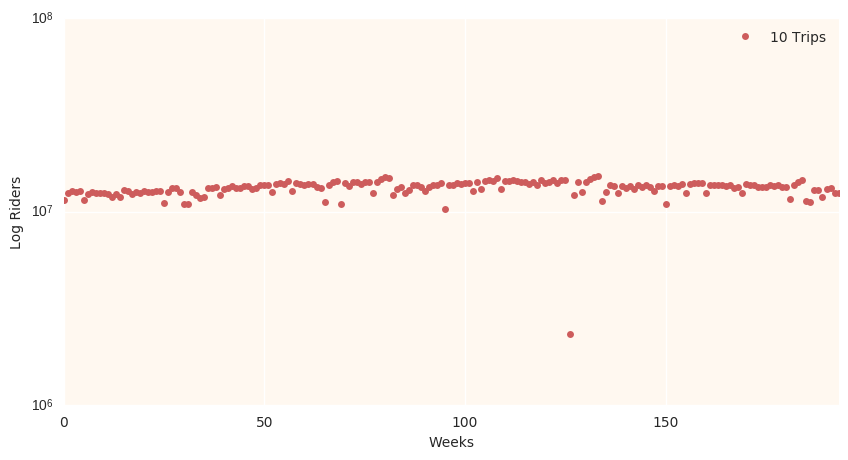

In [195]:
ax = mta_sumstation[0].plot(logy=True, figsize=(10,5), style=".", ms=10, color="IndianRed" , label = '10 Trips')
pl.legend()
pl.ylabel("Log Riders", fontsize=10)
pl.xlabel("Weeks", fontsize=10)

### Figure 1.  Plot the log ridership per week for the 10 Trips type, we can see clear there is a outlier showing a prominent event between 100 to 150 weeks.

In [196]:
thresholds = [mta_sumstation[0].mean() + 3 * mta_sumstation[0].std(), 
             mta_sumstation[0].mean() - 3 * mta_sumstation[0].std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

3-sigma thresholds 16889312.35 9595433.59


In [197]:
mta_sumstation[0].loc[(mta_sumstation[0] < thresholds[1])]

126    2331726.0
Name: 0, dtype: float64

In [198]:
dateindex[126:128]

DatetimeIndex(['2012-10-19', '2012-10-26'], dtype='datetime64[ns]', freq='7D')

### The outliers is due to Hurricane Sandy(October 22, 2012 ~November 2, 2012) which strikes NY that week. 

### Task 2:
#### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [199]:
# remove outlier
mta_sumstation = mta_sumstation.drop(mta_sumstation.index[126])

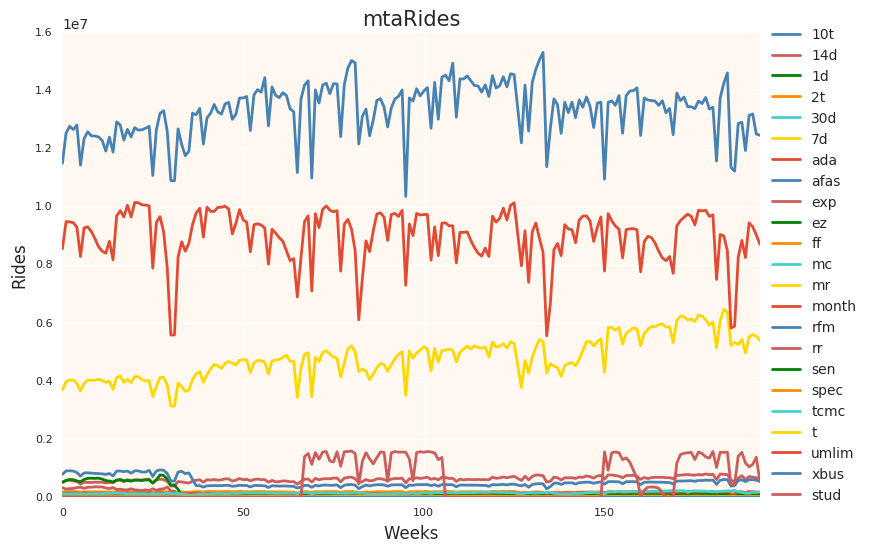

In [200]:
fig = pl.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for i in range(23):
    ax = mta_sumstation[i].plot(fontsize=8, label = ridetype[i])
ax.set_title("mtaRides", fontsize=15)
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.xlabel("Weeks", fontsize=12)
pl.ylabel("Rides", fontsize=12)

### Figure 2. Plot all types of riders per week. We can see from this plot that 10t riders are the most popular type.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


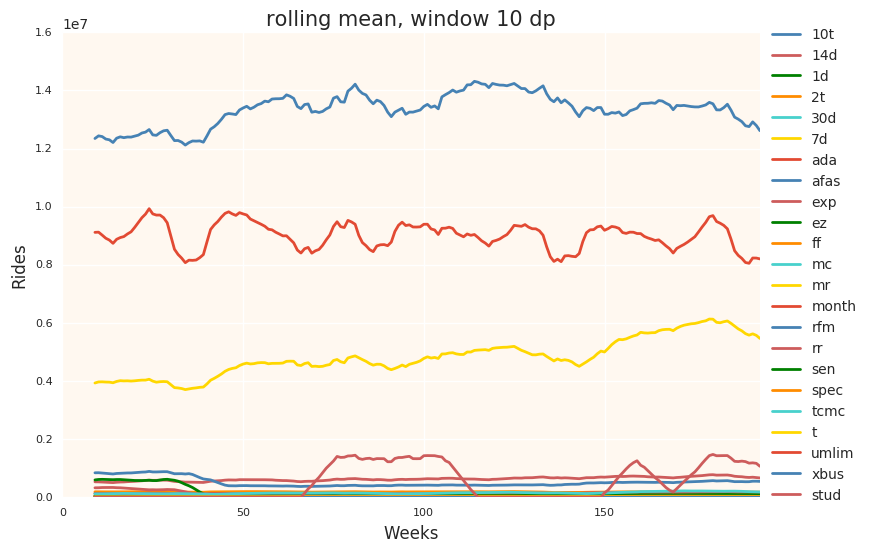

In [201]:
fig = pl.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for i in range(23):
    ax = pd.rolling_mean(mta_sumstation[i], 10).plot(fontsize=8, label = ridetype[i])
ax.set_title("rolling mean, window 10 dp", fontsize=15)
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.xlabel("Weeks", fontsize=12)
pl.ylabel("Rides", fontsize=12)

### Figure 3. Plot the 10 week rolling mean of all rider types per week to visually assess stationarity.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()


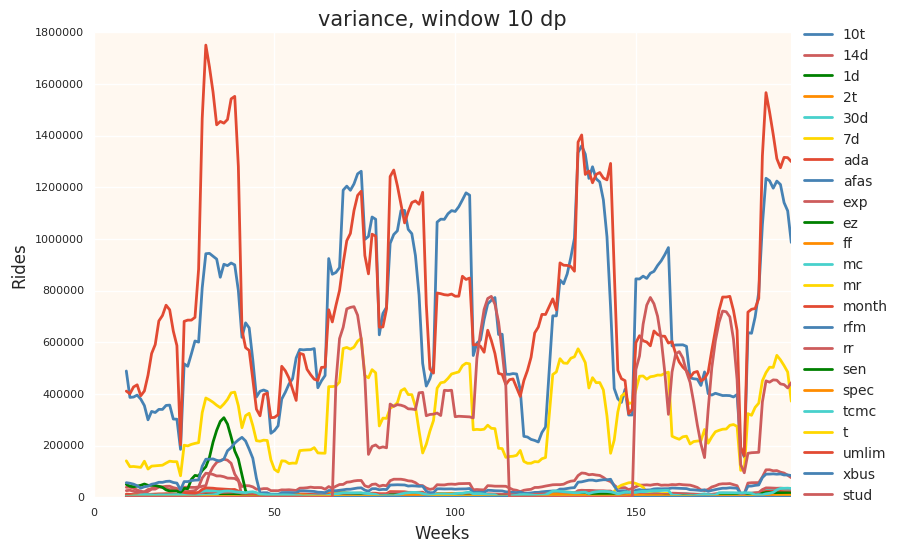

In [202]:
fig = pl.figure(figsize=(9,6))
ax = fig.add_subplot(111)
for i in range(23):
    ax = pd.rolling_std(mta_sumstation[i], 10).plot(fontsize=8, label = ridetype[i])
ax.set_title("variance, window 10 dp", fontsize=15)
pl.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
pl.xlabel("Weeks", fontsize=12)
pl.ylabel("Rides", fontsize=12)

#ax = pd.rolling_std(mta_sumstation[0], 10).plot(figsize=(12,8))
#ax.set_title("variance (rolling stdev,window 10 dp, ridertype:10 Trip)", fontsize=15)
#pl.xlabel("Weeks", fontsize=12)
#pl.ylabel("Rides", fontsize=12)

### Figure 4. Plot the variance(10 weeks) of all rider types per week to visually assess stationarity.

In [203]:
for i in range(23):
    print (ridetype[i] + ': flux ratio beginning to end: {}'
           .format(pd.rolling_std(mta_sumstation[i], 10)[193] / pd.rolling_std(mta_sumstation[i], 10)[9]))

10t: flux ratio beginning to end: 2.01732644221
14d: flux ratio beginning to end: 1.95521547454
1d: flux ratio beginning to end: 2.92405862185
2t: flux ratio beginning to end: 1.93664539771
30d: flux ratio beginning to end: 1.45181759724
7d: flux ratio beginning to end: 2.63406730493
ada: flux ratio beginning to end: 3.16023098062
afas: flux ratio beginning to end: 0.00213412538412
exp: flux ratio beginning to end: 7.3407898482e-05
ez: flux ratio beginning to end: 1.98707951634e-05
ff: flux ratio beginning to end: 1.76949255893
mc: flux ratio beginning to end: 3.30621131006
mr: flux ratio beginning to end: 3807.13435154
month: flux ratio beginning to end: 1.67890973908
rfm: flux ratio beginning to end: 1.48524577183
rr: flux ratio beginning to end: 6.90577107536
sen: flux ratio beginning to end: 9.09515527463
spec: flux ratio beginning to end: 6.02960595415
tcmc: flux ratio beginning to end: 8.72495414302
t: flux ratio beginning to end: 6.89855286677
umlim: flux ratio beginning to end:

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  app.launch_new_instance()


### Ridership types that have steadily increased in popularity : exp, mr, rr, sen, spec, tcmc, t, stud
### Ridership types that have steadily decreased in popularity : afas

### Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


In [204]:
mta_sumtype = pd.DataFrame(mta_sumtype).T
mta_sumtype.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [205]:
shape(mta_sumtype)

(194, 600)

In [206]:
# remove outlier
mta_sumtype = mta_sumtype.drop(mta_sumtype.index[126])

In [207]:
mta_sumtype.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


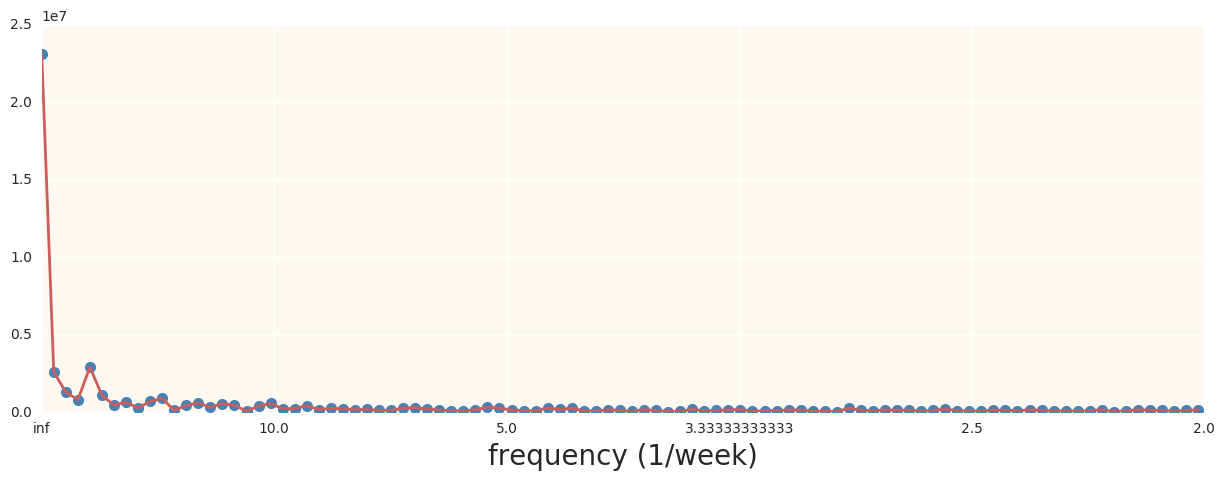

In [208]:
N = len(mta_sumtype)
f = np.abs(np.fft.rfft(mta_sumtype[0]))
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms = 8)
ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
pl.xlabel("frequency (1/week)", fontsize=20)

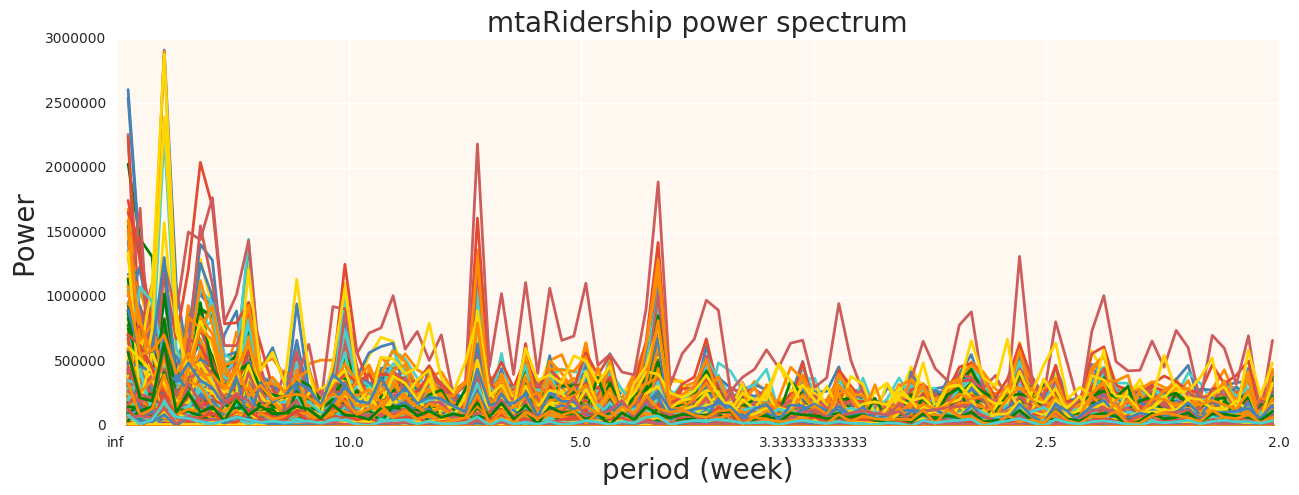

In [209]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(599):
    f = np.abs(np.fft.rfft(mta_sumtype[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xlim(0,1.0/2.0)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
pl.xlabel("period (week)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("mtaRidership power spectrum", fontsize=20)

### Figure 5. Plot the power spctrum for all mtaridership.

### EXTRA CREDIT: Cluster.

In [144]:
from scipy import stats
# PCA module
from sklearn.decomposition import PCA

In [176]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
tots = tots[tots.std(1)>0]
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
tots_std = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0)

In [177]:
shape(tots_std)

(7660, 194)

In [178]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.cm as cm

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

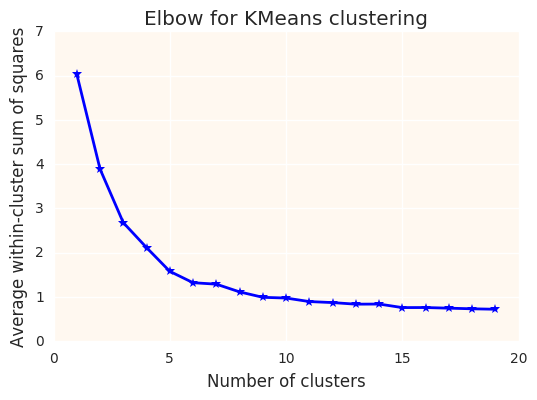

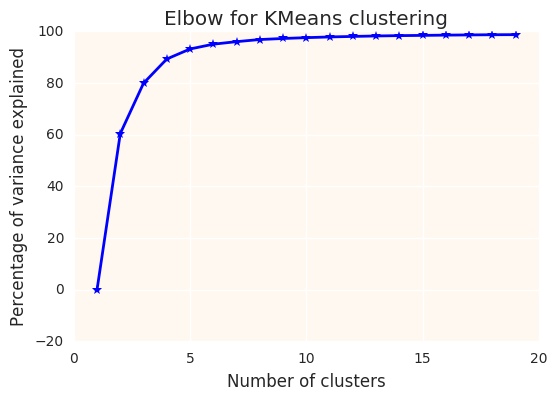

In [174]:
elbow(tots_std,range(1,20))

### We can more or less see a number of 6 clustering. 

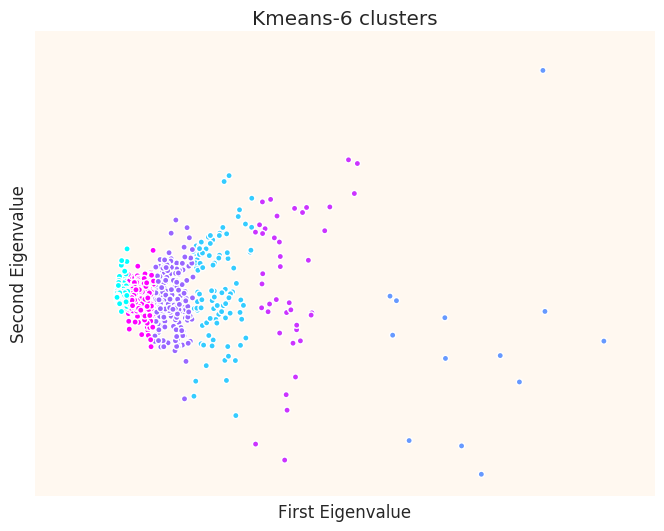

In [180]:
n = 6 # number of clusters

#train the model.
km = KMeans(random_state = 324,n_clusters = n)
res = km.fit(tots_std)
pca = PCA(194)
Xproj = pca.fit_transform(tots_std)
#Plot
plt.figure(figsize=(8, 6))

plt.scatter(Xproj[:, 0], Xproj[:, 1], c=res.labels_, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()